In [1]:
# Re-import necessary libraries and re-define functions due to reset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Redefine create_sequences function
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 3]  # 3 corresponds to 'Close' column after scaling
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Re-load and preprocess the data
file_path = 'C:\\Users\\data\\samsung2.csv'
samsung_data = pd.read_csv(file_path)
features = samsung_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_multi.fit_transform(features)

# Create 60-day input sequences from the scaled features
sequence_length = 60  # Number of days
X_multi, y_multi = create_sequences(scaled_features, sequence_length)

# Split the data into training and testing sets for the multivariate case
train_size_multi = int(len(X_multi) * 0.8)
X_train_multi, X_test_multi = X_multi[:train_size_multi], X_multi[train_size_multi:]
y_train_multi, y_test_multi = y_multi[:train_size_multi], y_multi[train_size_multi:]

# Show the shapes of the resulting datasets for the multivariate case
(X_train_multi.shape, X_test_multi.shape), (y_train_multi.shape, y_test_multi.shape)


(((1125, 60, 5), (282, 60, 5)), ((1125,), (282,)))

In [2]:
# PyTorch and LSTM model re-import and re-definition due to reset
import torch
import torch.nn as nn

# Redefine the LSTM model to handle multivariate input
class MultiFeatureStockPredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(MultiFeatureStockPredictorLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define the LSTM layer(s)
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.lstm.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.lstm.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        
        # Get LSTM outputs
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        
        # Get the prediction from the last time step
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

# Adjusted model parameters for multivariate input
input_size = 5  # Number of features (Open, High, Low, Close, Volume)
hidden_layer_size = 50  # Number of hidden units in each LSTM layer
output_size = 1  # Predicting a single 'Close' price
num_layers = 2  # Number of LSTM layers

# Initialize the adjusted model
multi_feature_model = MultiFeatureStockPredictorLSTM(input_size, hidden_layer_size, output_size, num_layers)
multi_feature_model


MultiFeatureStockPredictorLSTM(
  (lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [3]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(multi_feature_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensors = torch.Tensor(X_train_multi)
y_train_tensors = torch.Tensor(y_train_multi).view(-1, 1)
X_test_tensors = torch.Tensor(X_test_multi)
y_test_tensors = torch.Tensor(y_test_multi).view(-1, 1)

# Set the number of epochs and initialize a variable to track the minimum test loss
num_epochs = 100
min_test_loss = np.inf

# Training loop
for epoch in range(num_epochs):
    multi_feature_model.train()
    optimizer.zero_grad()
    output = multi_feature_model(X_train_tensors)
    loss = loss_function(output, y_train_tensors)
    loss.backward()
    optimizer.step()
    
    # Evaluation on the test data
    multi_feature_model.eval()
    test_predictions = multi_feature_model(X_test_tensors)
    test_loss = loss_function(test_predictions, y_test_tensors)
    
    # Save the model if the test loss decreased
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(multi_feature_model.state_dict(), 'C:\\Users\\data\\best_model.pth')  # Save the best model
    
    # Print the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Test Loss: {test_loss.item()}')

# Note: The actual training might take some time depending on your system's capabilities.


Epoch 1/100, Training Loss: 0.14984014630317688, Test Loss: 0.17750607430934906
Epoch 11/100, Training Loss: 0.04692854732275009, Test Loss: 0.014154213480651379
Epoch 21/100, Training Loss: 0.03214108943939209, Test Loss: 0.0067051793448626995
Epoch 31/100, Training Loss: 0.009328282438218594, Test Loss: 0.0011213799007236958
Epoch 41/100, Training Loss: 0.004058103077113628, Test Loss: 0.0058054435066878796
Epoch 51/100, Training Loss: 0.0029506736900657415, Test Loss: 0.003739840118214488
Epoch 61/100, Training Loss: 0.0019187919097021222, Test Loss: 0.001678821281529963
Epoch 71/100, Training Loss: 0.0015939042204990983, Test Loss: 0.000950260553508997
Epoch 81/100, Training Loss: 0.0014055462088435888, Test Loss: 0.00095232023159042
Epoch 91/100, Training Loss: 0.0012996237492188811, Test Loss: 0.0008752817520871758


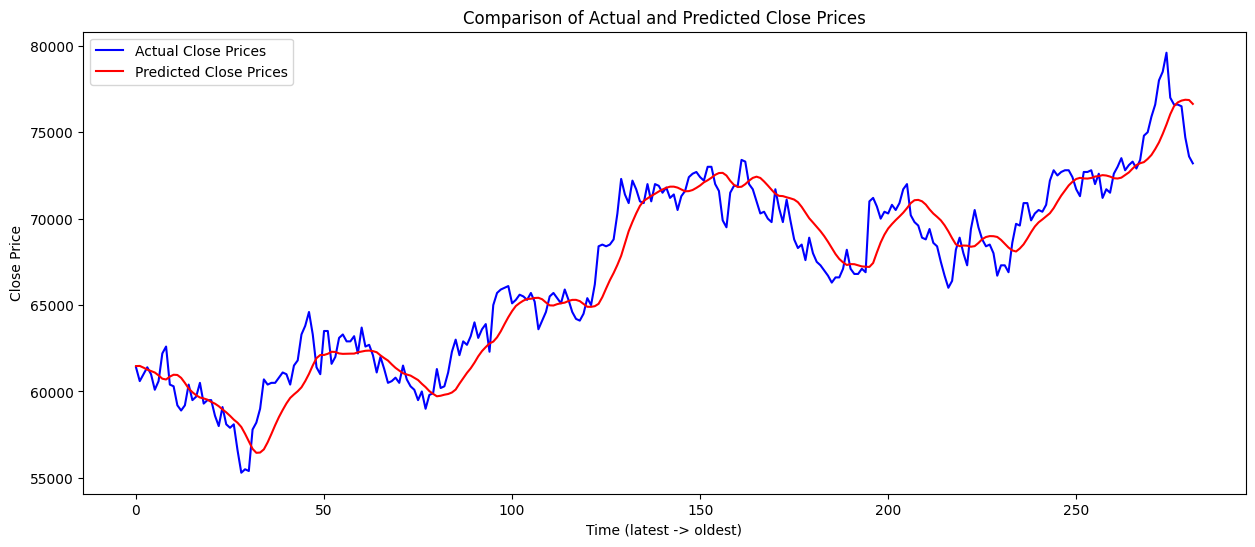

In [4]:
# Load the best model
best_model_path = 'C:\\Users\\data\\best_model.pth'
multi_feature_model.load_state_dict(torch.load(best_model_path))

# Make predictions with the best model
multi_feature_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    predicted_test = multi_feature_model(X_test_tensors).cpu().numpy()

# Inverse transform the predictions and actual values to their original scale
predicted_test_prices = scaler_multi.inverse_transform(
    np.concatenate([X_test_multi[:, -1, :3], predicted_test, X_test_multi[:, -1, 4:]], axis=1)
)[:, 3]  # Select only the 'Close' column

actual_test_prices = scaler_multi.inverse_transform(
    np.concatenate([X_test_multi[:, -1, :3], y_test_multi.reshape(-1, 1), X_test_multi[:, -1, 4:]], axis=1)
)[:, 3]  # Select only the 'Close' column

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(actual_test_prices, label='Actual Close Prices', color='blue')
plt.plot(predicted_test_prices, label='Predicted Close Prices', color='red')
plt.title('Comparison of Actual and Predicted Close Prices')
plt.xlabel('Time (latest -> oldest)')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [6]:
last_5_predicted_close_prices = predicted_test_prices[-5:]
print(last_5_predicted_close_prices)


[76726.03979111 76830.60410023 76878.97307277 76863.39056492
 76639.26673532]


In [ ]:
#Hi leaving a message for you, But you are fucked up